In [4]:
from __future__ import division #To properly handle floating point divisions.

In [5]:
# setupt tf-idf baseline
import pprint
import math
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import json

In [6]:
# Main

# Load in Submissions and imdb information
QA_file = open("./dict1.json", 'r')
SummarySynopsis_file = open("./dict2.json", 'r')
QA_object = json.load(QA_file)
SS_object = json.load(SummarySynopsis_file)


# Build good format from imdb information for one doc
def listify(SS_object_item):
    stringList = list()
    for key, value in SS_object_item['Information: '].items():
        if key == 'id: ':
            stringList.insert(0, value)
        if key == 'id: ':
            continue
        if type(value) == list:
            stringList.append(' '.join(value))
        else: 
            stringList.append(value)
    return ' '.join(stringList)


# apply to multiple docs
def document_builder(SS_list):
    document_list = list()
    for item in SS_list:
        document_list.append(listify(item))
    return document_list

# build dataset of imdb information
SS = document_builder(SS_object)


# Set up for tf idf for QA information
# Add title and context together
QA = list()
for sentence in QA_object:
    QA.append(sentence['Imdb id: '] + ' ' + sentence['Submission title: '] + sentence['Context: '])
    
# TODO: sort score with imdb id as well? so a tuple with (imdb id query cosine similarity on: score sorted)

from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict

# setup vectorizer for tf idf, remove stopwords
vectorizer = TfidfVectorizer(stop_words = 'english')

# fit -> transform vector on imdb docs
imdb_vecs = vectorizer.fit_transform(SS) #docTFIDF

# Get cosine similarity between query and all imdb docs
def get_tf_idf_query_similarity(vectorizer, imdb_docs, docs_tfidf, query):
    """
    :param set vectorizer: Set containing vectorizer as (x, y, z)
    
    :return list: A list of tuples with (imdb_id, cosine sim)
    """
    # Get tf_idf cosine similarity for one query
    imdb_ids = []
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    for doc in imdb_docs:
         # grab imdb id
        imdb_ids.append(doc[:7])
    return list(zip(imdb_ids, cosineSimilarities))


def get_tfidf_all_queries(vectorizer, imdb_docs, docs_tfidf, queries):
    results = {}
    for query in queries:
        score = get_tf_idf_query_similarity(vectorizer, imdb_docs, imdb_vecs, query)
        results[query] = ({'Imdb id: ': query[:7],'Score: ': score})
    return results


submission_movie_pairs = []
for movie_pair in QA_object:
    submission_movie_pairs.append((movie_pair['Submission_id: '], movie_pair['Imdb id: ']))


# Calculate score for one submission id
pytrec_query = get_tf_idf_query_similarity(vectorizer, SS, imdb_vecs, QA[0])

gt = {}
# assign the correct answer with 1, everythin else with 0 
for submission_id, movie_id in submission_movie_pairs:
  # the relevance is always 1
  gt[submission_id] = {
    movie_id : 1
  }

#print(gt)


results = {}

# you need QA[submission_id] and fill in the scores with {imdb_id:score, imdb_id2:score2 etc} for pytrec
# for submission_id in submission_id_list:
i = 0
for submission_id in QA_object:
    #print(submission_id[:7])
    results[submission_id['Submission_id: ']] = {}
    for submission in QA:
        pytrec_vect = get_tf_idf_query_similarity(vectorizer, SS, imdb_vecs, submission)
        idx = [x[0] for x in pytrec_vect]
        scorex = [y[1] for y in pytrec_vect]
        for n, x in enumerate(idx):
            results[submission_id['Submission_id: ']][x] = scorex[n]
        
#pprint.pprint(results)

evaluator = pytrec_eval.RelevanceEvaluator(
    gt, {'map', 'ndcg'})

print(json.dumps(evaluator.evaluate(results), indent=1))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
"""
Load the JSON files of the QuestionAnswer-data (QA) and SummarySynopsis-data (SS)
"""
QA_file = open("./dict1.json", 'r')
SummarySynopsis_file = open("./dict2.json", 'r')
QA_object = json.load(QA_file)
SS_object = json.load(SummarySynopsis_file)

In [116]:
print('Query: ', QA[47])
print()
print('Answer: ', SS[47])

Query:  0097419 [TOMT][MOVIE][80s/90s] ... in which a few kids go trick or treating with an old wheelchair-bound dude dressed in a giant eyeball costume.I think the kids were scared of him first... but went on to befriend the disabled fellow. Goonies vibes.

Answer:  0097419 This is a tale about two children who are put in a foster home, and then on Halloween they breakout and are rescued by their eccentric grandfather who is in a Halloween costume of an eyeball. They then go to Georges island to try and find the treasure of Captain Kidd.::Andrew Hazeden <Dover99@mailexcite.com> Tina Cross George's Island Adventure Drama Family


In [7]:
INFORMATION_KEY = 'Information: '
CAST_ID_KEY = 'id: '
IMDB_KEY = 'Imdb id: '
SUBMISSION_ID_KEY = 'Submission_id: '
SUBMISSION_TITLE_KEY = 'Submission title: '
CONTEXT_KEY = 'Context: '

# Make string format for tf-idf from list of dicts
def listify(doc_dict):
    """
    param:
    doc_dict: dict of a document
    """
    stringList = list()
    for key, value in doc_dict[INFORMATION_KEY].items():
        if key == CAST_ID_KEY:
            continue
        if type(value) == list:
            stringList.append(' '.join(value))
        else: 
            stringList.append(value)
    stringList.insert(0, doc_dict[IMDB_KEY])
    return ' '.join(stringList)


def document_builder(SS_list):
    document_list = list()
    for item in SS_list:
        document_list.append(listify(item))
    return document_list

In [8]:
SS = document_builder(SS_object)

In [9]:
def QA_build(QA_object):
    """
    Build proper format from QA_object for tf-idf
    """
    QA = list()
    # Add title and context together, tokenize the sentence, remove stopwords and remove duplicates
    for sentence in QA_object:
        #print(sentence[CONTEXT_KEY])
        QA.append(sentence[IMDB_KEY] + ' ' + sentence[SUBMISSION_TITLE_KEY] + sentence[CONTEXT_KEY])
    return QA
    

In [10]:
QA = QA_build(QA_object)

In [11]:
# TODO: sort score with imdb id as well? so a tuple with (imdb id query cosine similarity on: score sorted)

from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict

vectorizer = TfidfVectorizer(stop_words = 'english')
imdb_vecs = vectorizer.fit_transform(SS) #docTFIDF

def get_tf_idf_query_similarity(vectorizer, imdb_docs, docs_tfidf, query):
    # Get tf_idf cosine similarity for one query
    imdb_ids = []
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    for doc in imdb_docs:
        imdb_ids.append(doc[:7])
    # return zipped list with imdb ids and their cosine similarities 
    # to original submission film in desc. order
    return list(sorted(zip(imdb_ids, cosineSimilarities), key=lambda x: x[1], reverse=True))
    #return list(zip(imdb_ids, cosineSimilarities))


def get_tfidf_all_queries(vectorizer, imdb_docs, docs_tfidf, queries):
    results = {}
    for query in queries:
        score = get_tf_idf_query_similarity(vectorizer, imdb_docs, imdb_vecs, query)
        #score = sorted(score, key=getKey, reverse=True)
        results = {'Imdb id: ': query[:7],'Score: ': score}
        #results[query] = {'Imdb id: ': query[:7],'Score: ': score}
        #print(key, value in results)
        #results = OrderedDict(sorted(results.items(), key=lambda kv: kv[1]['Score: '], reverse=True))
        #results = {k: v for k, v in sorted(results.items(), key=lambda _: -_[1])}
    return results 

def get_score(vectorizer, imdb_docs, docs_tfidf, query):
    query_tfidf = vectorizer.transform([query])
    return cosine_similarity(query_tfidf, docs_tfidf).flatten()

In [12]:
import json
import pytrec_eval

# Make tuples of submission id and corresponding imdb id
# From QA_object, so QA_object[0] is a submission
submission_movie_pairs = []
for movie_pair in QA_object:
    submission_movie_pairs.append((movie_pair[SUBMISSION_ID_KEY], movie_pair[IMDB_KEY]))


# Calculate score for one submission id
#pytrec_query = get_tf_idf_query_similarity(vectorizer, SS, imdb_vecs, QA[0])

gt = {}
# assign the correct answer with 1, everythin else with 0 
for submission_id, movie_id in submission_movie_pairs:
  # the relevance is always 1
  gt[submission_id] = {
    movie_id : 1
  }

#print(gt)


results = {}

# you need QA[submission_id] and fill in the scores with {imdb_id:score, imdb_id2:score2 etc} for pytrec
# for submission_id in submission_id_list:
i = 0
for submission_id in QA_object:
    results[submission_id['Submission_id: ']] = {}
    for submission in QA:
        pytrec_vect = get_tf_idf_query_similarity(vectorizer, SS, imdb_vecs, submission)
        idx = [x[0] for x in pytrec_vect]
        scorex = [y[1] for y in pytrec_vect]
        for n, x in enumerate(idx):
            results[submission_id['Submission_id: ']][x] = scorex[n]
        
#pprint.pprint(results)

evaluator = pytrec_eval.RelevanceEvaluator(
    gt, {'map', 'ndcg', 'recall'})

print(json.dumps(evaluator.evaluate(results), indent=1))

{
 "cyuqj9": {
  "map": 0.0016366612111292963,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 0.0,
  "recall_1000": 1.0,
  "ndcg": 0.10802183261548809
 },
 "dhqkmu": {
  "map": 0.0020491803278688526,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg": 0.1119358212213972
 },
 "a88que": {
  "map": 0.0035587188612099642,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "recall_1000": 1.0,
  "ndcg": 0.1228568942814387
 },
 "ctju0t": {
  "map": 0.0028169014084507044,
  "recall_5": 0.0,
  "recall_10": 0.0,
  "recall_15": 0.0,
  "recall_20": 0.0,
  "recall_30": 0.0,
  "recall_100": 0.0,
  "recall_200": 0.0,
  "recall_500": 1.0,
  "r

In [89]:
from scipy import mean
import pandas as pd
import pytrec_eval

In [17]:
# recall 10-100-1000
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [87]:
results2_pytrec = evaluator.evaluate(results)

map mean:  0.009404021570710998
ndcg mean:  0.12840189972706037
recall 5 mean:  0.006305170239596469
recall 10 mean:  0.012610340479192938
recall 20 mean:  0.02648171500630517
recall 30 mean:  0.0403530895334174
recall 100 mean:  0.13240857503152584
recall 1000 mean:  0.987389659520807


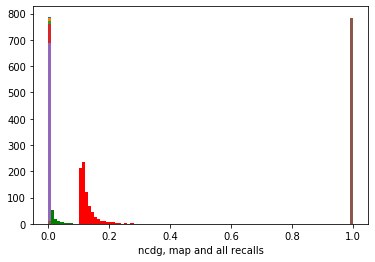

In [63]:
# Make lists, np.mean for averages
map_list = []
map_average = []
recall_5_average = []
recall_10_average = []
recall_20_average = []
recall_30_average = []
recall_100_average = []
recall_1000_average = []
ndcg_average = []
#counter = 0


for key in results2_pytrec:
    nested_dict = results2_pytrec[key]
    for key, value in nested_dict.items():
        if key == 'map':
            map_average.append(value)
        if key == 'recall_5':
            recall_5_average.append(value)
        if key == 'recall_10':
            recall_10_average.append(value)
        if key == 'recall_20':
            recall_20_average.append(value)
        if key == 'recall_30':
            recall_30_average.append(value)
        if key == 'recall_100':
            recall_100_average.append(value)
        if key == 'recall_1000':
            recall_1000_average.append(value)
        if key == 'ndcg':
            ndcg_average.append(value)

#print(counter)    
plt.hist(map_average, bins=100,color = 'green')
plt.hist(ndcg_average, bins=100, color = 'red')
plt.hist(recall_5_average, bins=100)
plt.hist(recall_10_average, bins=100)
plt.hist(recall_20_average, bins=100)
plt.hist(recall_30_average, bins=100)
plt.hist(recall_100_average, bins=100)
plt.hist(recall_1000_average, bins=100)
plt.xlabel('ncdg, map and all recalls')

map_list = map_average
ndcg_list = ndcg_average
re_5_list = recall_5_average
re_10_list = recall_10_average
re_20_list = recall_20_average
re_30_list = recall_30_average
re_100_list = recall_100_average
re_1000_list = recall_1000_average



map_average = np.mean(map_average)
ndcg_average = np.mean(ndcg_average)
recall_5_average = np.mean(recall_5_average)
recall_10_average = np.mean(recall_10_average)
recall_20_average = np.mean(recall_20_average)
recall_30_average = np.mean(recall_30_average)
recall_100_average = np.mean(recall_100_average)
recall_1000_average = np.mean(recall_1000_average)



print('map mean: ', map_average)
print('ndcg mean: ', ndcg_average)
print('recall 5 mean: ', recall_5_average)
print('recall 10 mean: ', recall_10_average)
print('recall 20 mean: ', recall_20_average)
print('recall 30 mean: ', recall_30_average)
print('recall 100 mean: ', recall_100_average)
print('recall 1000 mean: ', recall_1000_average)



data = {'map average: ': [map_average],
       'ncdg average: ': [ndcg_average],
       'recall@5 average: ': [recall_5_average],
       'recall@10 average: ': [recall_10_average],
       'recall@20 average: ': [recall_20_average],
       'recall@30 average: ': [recall_30_average],
       'recall@100 average: ': [recall_100_average],
       'recall@1000 average: ': [recall_1000_average],
       }

Text(0.5, 1.0, 'MAP values for all submissions')

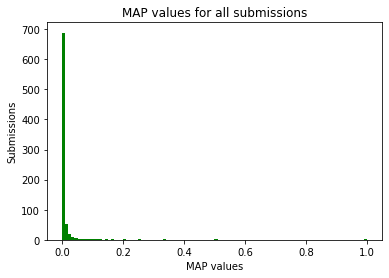

In [85]:
plt.hist(map_list, bins=100, color = 'green')
plt.xlabel('MAP values')
plt.ylabel('Submissions')
plt.title('MAP values for all submissions')

Text(0, 0.5, 'Submissions')

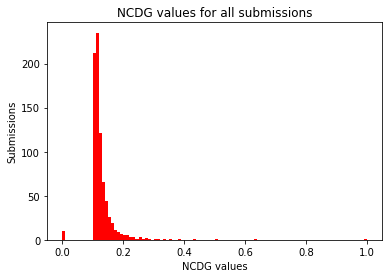

In [86]:
plt.title('NCDG values for all submissions')
plt.hist(ndcg_list, bins=100, color = 'red')
plt.xlabel('NCDG values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

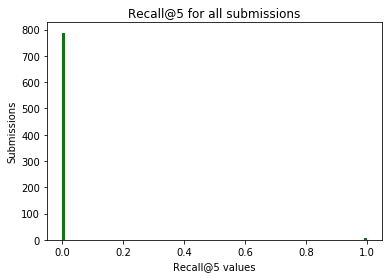

In [78]:
plt.title('Recall@5 for all submissions')
plt.hist(re_5_list, bins=100, color = 'green')
plt.xlabel('Recall@5 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

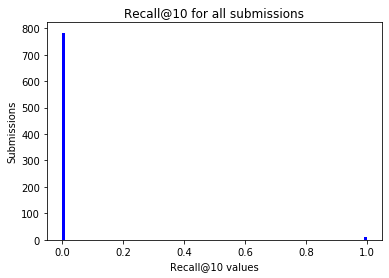

In [79]:
plt.title('Recall@10 for all submissions')
plt.hist(re_10_list, bins=100, color = 'blue')
plt.xlabel('Recall@10 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

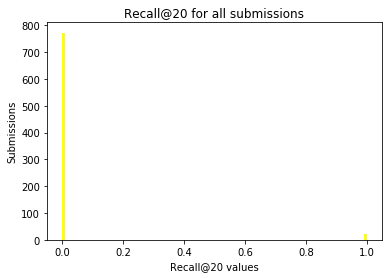

In [80]:
plt.title('Recall@20 for all submissions')
plt.hist(re_20_list, bins=100, color = 'yellow')
plt.xlabel('Recall@20 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

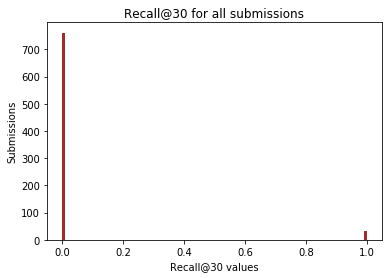

In [81]:
plt.title('Recall@30 for all submissions')
plt.hist(re_30_list, bins=100, color = 'brown')
plt.xlabel('Recall@30 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

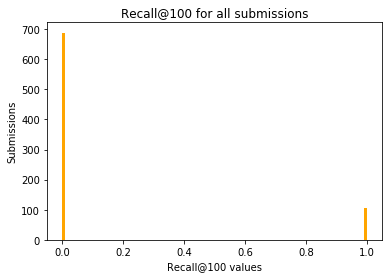

In [82]:
plt.title('Recall@100 for all submissions')
plt.hist(re_100_list, bins=100, color = 'orange')
plt.xlabel('Recall@100 values')
plt.ylabel('Submissions')

Text(0, 0.5, 'Submissions')

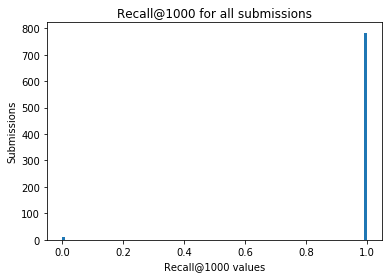

In [83]:
plt.title('Recall@1000 for all submissions')
plt.hist(re_1000_list, bins=100)
plt.xlabel('Recall@1000 values')
plt.ylabel('Submissions')

In [21]:
import pandas as pd
df = pd.DataFrame(data, columns = ['map average: ', 'ncdg average: ', 'recall@5 average: ', 'recall@10 average: ', 'recall@25 average: ', 'recall@50 average: '])

In [22]:
print(df)

   map average:   ncdg average:   recall@5 average:   recall@10 average:   \
0       0.009404        0.128402            0.006305              0.01261   

   recall@25 average:   recall@50 average:   
0                  NaN                  NaN  


In [86]:
KEYS = ['map','ncdg'] + ['recall_{}'.format(i) for i in [5,10,50]]
my_dict = results2_pytrec

for key in my_dict:
    nested_dict = my_dict[key]
    all_values_i_want = [nested_dict[key2] for key2 in nested_dict if key2 in KEYS]
    average = sum(all_values_i_want) / len(all_values_i_want)
    print(average)
    

0.0005455537370430988
0.0006830601092896175
0.0011862396204033213
0.0009389671361502348
0.005128205128205128
0.0005757052389176741
0.000749063670411985
0.0010416666666666667
0.0006093845216331506
0.0011737089201877935
0.001044932079414838
0.0004604051565377532
0.0009633911368015414
0.0007558578987150416
0.0023809523809523807
0.0005837711617046118
0.002347417840375587
0.012345679012345678
0.0004492362982929021
0.0005482456140350877
0.0006693440428380187
0.0009057971014492754
0.0008525149190110828
0.0004901960784313725
0.0010649627263045792
0.0009082652134423251
0.0004775549188156638
0.0010683760683760683
0.0021367521367521365
0.023809523809523808
0.0005555555555555556
0.00048661800486618
0.00228310502283105
0.0012626262626262627
0.0012578616352201257
0.0017452006980802793
0.0010224948875255625
0.0022371364653243847
0.0005128205128205128
0.0006523157208088715
0.002207505518763797
0.0005868544600938967
0.00046425255338904364
0.0044444444444444444
0.0007183908045977011
0.003003003003003003

In [63]:
# Save as 
with open('pytrec_eval_results_sorted_keys.json', 'w') as fp:
    json.dump(results_pytrec, fp, sort_keys =True, indent=4)

In [184]:
import csv

# Save as csv
with open('tf_idf_cosine_similarities.csv','w') as f:
    w = csv.writer(f)
    w.writerows(results.items())

In [196]:
#parsed = json.loads('tf_idf_cosine_similarities.json')
#print(json.dumps(parsed, indent=4, sort_keys=True))

In [ ]:
import pickle

with open('outfile', 'wb') as fp:
    pickle.dump(results, fp)

In [27]:
sparse.save_npz("QQ_SS_tfidf_vectors.npz", results[0])

Use tf-idf  for bm25
build all subsections
merge background and related work
implement bm25 and tf idf correctly
specific research question: contributions
index maken
explain reddit
writing alongside experiments
read slides sam skype precision recall etc

add movie id to data from tf-idf SS_object
vectorizer = TfidfVecotrizer()
vectorizer.fit_transform(SS_test_sentence)
vectorizer.transform(QA_tokenized)

calculate_tfidf_vector
globally
pytrec eval
